In [1]:
%run utils.py

In [2]:
from utils import ConvRelu
from torch import nn

def vgg_block(conv_in, conv_out, conv_num):
    layers = []
    layers.append(ConvRelu(conv_in, conv_out, kernel_size=3, padding=1))
    for i in range(conv_num - 1):
        layers.append(ConvRelu(conv_out, conv_out, kernel_size=3, padding=1))

    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

block = vgg_block(3, 64, 2)
print(block)

Sequential(
  (0): ConvRelu(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (1): ConvRelu(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [3]:
class VggBlock(nn.Module):
    def __init__(self, conv_in, conv_out, conv_num):
        super(VggBlock, self).__init__()
        layers = []
        layers.append(ConvRelu(conv_in, conv_out, kernel_size=3, padding=1))
        for i in range(conv_num - 1):
            layers.append(ConvRelu(conv_out, conv_out, kernel_size=3, padding=1))

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

block = VggBlock(3, 64, 2)
print(block)

VggBlock(
  (block): Sequential(
    (0): ConvRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (1): ConvRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
)


In [4]:
from utils import LinerRelu

class Vgg16(nn.Module):
    def __init__(self, dropout=0.5):
        super(Vgg16, self).__init__()
        self.block1 = VggBlock(3, 64, 2)
        self.block2 = VggBlock(64, 128, 2)
        self.block3 = VggBlock(128, 256, 3)
        self.block4 = VggBlock(256, 512, 3)
        self.block5 = VggBlock(512, 512, 3)
        self.fc1 = LinerRelu(512, 256, dropout=dropout)
        self.fc2 = LinerRelu(256, 128, dropout=dropout)
        self.fc3 = LinerRelu(128, 10, dropout=dropout)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = nn.Flatten()(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [5]:
from torchinfo import summary

vgg16 = Vgg16()
summary(vgg16, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Vgg16                                    [1, 10]                   --
├─VggBlock: 1-1                          [1, 64, 16, 16]           --
│    └─Sequential: 2-1                   [1, 64, 16, 16]           --
│    │    └─ConvRelu: 3-1                [1, 64, 32, 32]           1,792
│    │    └─ConvRelu: 3-2                [1, 64, 32, 32]           36,928
│    │    └─MaxPool2d: 3-3               [1, 64, 16, 16]           --
├─VggBlock: 1-2                          [1, 128, 8, 8]            --
│    └─Sequential: 2-2                   [1, 128, 8, 8]            --
│    │    └─ConvRelu: 3-4                [1, 128, 16, 16]          73,856
│    │    └─ConvRelu: 3-5                [1, 128, 16, 16]          147,584
│    │    └─MaxPool2d: 3-6               [1, 128, 8, 8]            --
├─VggBlock: 1-3                          [1, 256, 4, 4]            --
│    └─Sequential: 2-3                   [1, 256, 4, 4]            --

In [6]:
from torchvision import datasets
from utils import train_val_split

full = datasets.CIFAR10(root="./data", train=True, download=True)
test = datasets.CIFAR10(root="./data", train=False, download=True)
train, valid = train_val_split(full, seed=666)

print(len(train), len(valid), len(test))

Files already downloaded and verified
Files already downloaded and verified
40000 10000 10000


In [7]:
from utils import PackDataset
from torchvision import transforms

train_data = PackDataset(train, transform=transforms.ToTensor())
valid_data = PackDataset(valid, transform=transforms.ToTensor())
test_data = PackDataset(test, transform=transforms.ToTensor())

image, label = train_data[0]
print(image.size())

torch.Size([3, 32, 32])


In [8]:
import json
from utils import control_callbacks
from sklearn.model_selection import ParameterGrid
import torch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

In [ ]:
epochs = 15
param_grid = {
    'lr': [0.001, 0.0005, 0.0001],
    'dropout': [0.5, 0.3, 0.2]
}

results = {
    'best_params': None,
    'best_acc': 0.0,
    'all_results': []
}

calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
for params in ParameterGrid(param_grid):
    print(f"\nTraining with params: {params}")
    vgg = Vgg16(params['dropout'])
    net = NeuralNetClassifier(
        vgg,
        criterion=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        lr=params['lr'],
        batch_size=2048,
        max_epochs=epochs,
        train_split=predefined_split(valid_data),
        device='cuda' if torch.cuda.is_available() else 'cpu',
        callbacks=calls,
        classes=list(range(10)),
    )
    net.fit(X=train_data, y=None)
    valid_acc = max(net.history[:, 'valid_acc'])
    current_result = {'params': params, 'valid_acc': valid_acc}
    results['all_results'].append(current_result)

    if valid_acc > results['best_acc']:
        results['best_acc'] = valid_acc
        results['best_params'] = params

    print(f"\nBest params: {results['best_params']}, best acc: {results['best_acc']}")

with open('./data/hyperparam_results.json', 'w') as f:
    json.dump(results, f, indent=2)


Training with params: {'dropout': 0.5, 'lr': 0.001}


In [26]:
epochs = 50
vgg = Vgg16(0.3)
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
full_data = PackDataset(full, transform=transforms.ToTensor())
net = NeuralNetClassifier(
    vgg,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.0001,
    batch_size=2048,
    max_epochs=epochs,
    train_split=predefined_split(test_data),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls,
    classes=list(range(10)),
)
net.fit(full_data, y=None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr      dur
-------  -----------  ------------  -----------  ------------  ----  ------  -------
      1       0.1482        2.2613       0.2150        2.1284     +  0.0001  24.1931
      2       0.2481        2.1186       0.3802        1.8842     +  0.0001  24.4257
      3       0.3103        2.0060       0.4099        1.7984     +  0.0001  24.7189
      4       0.3483        1.9252       0.4788        1.6667     +  0.0001  24.7000
      5       0.3776        1.8628       0.5013        1.5812     +  0.0001  24.7995
      6       0.3954        1.8205       0.5171        1.5734     +  0.0001  24.9996
      7       0.4071        1.7865       0.5372        1.5071     +  0.0001  25.0132
      8       0.4258        1.7356       0.5540        1.4579     +  0.0001  25.0404
      9       0.4408        1.6969       0.5368        1.4937        0.0001  25.2933
     10       0.4456        1.6803       0.5744        1.4162    

,module,Vgg16( (blo...e=False) ) )
,criterion,<class 'torch...sEntropyLoss'>
,train_split,functools.par...7efacb122020>)
,classes,"[0, 1, ...]"
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.0001
,max_epochs,50
,batch_size,2048
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


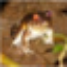

In [11]:
from utils import show_tensor_image

def show_trans(tans_arr):
    compose = transforms.Compose(tans_arr)
    train_data = PackDataset(full, transform=compose)
    image, _ = train_data[0]
    show_tensor_image(image)

show_trans([transforms.Resize(size=67), transforms.ToTensor()])

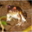

In [12]:
show_trans([
  transforms.RandomHorizontalFlip(1), transforms.ToTensor()
])

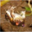

In [14]:
show_trans([
  transforms.RandomVerticalFlip(1), transforms.ToTensor()
])

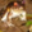

In [15]:
show_trans([
    transforms.RandomResizedCrop(size=32, scale=(0.6, 0.6), ratio=(1.0, 1.0)),
    transforms.ToTensor()
])

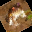

In [22]:
show_trans([transforms.RandomRotation(30), transforms.ToTensor()])

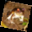

In [32]:
from PIL import Image
import random

class RandomRotateExpandTransform:
    def __init__(self, degrees=30, fill=0, interpolation=Image.BICUBIC):
        if isinstance(degrees, (tuple, list)):
            self.min_angle, self.max_angle = degrees
        else:
            self.min_angle = -degrees
            self.max_angle = degrees

        self.fill = fill
        self.interpolation = interpolation

    def __call__(self, img: Image.Image) -> Image.Image:
        if not isinstance(img, Image.Image):
            raise TypeError("输入图像必须是 PIL.Image.Image 类型")

        orig_size = img.size
        angle = random.uniform(self.min_angle, self.max_angle)

        rotated = img.rotate(
            angle,
            resample=self.interpolation,
            expand=True,
            fillcolor=self.fill
        )

        resized = rotated.resize(orig_size, resample=self.interpolation)
        return resized

show_trans([RandomRotateExpandTransform(30), transforms.Resize(size=32), transforms.ToTensor()])

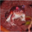

In [35]:
show_trans([
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.4, hue=0.1),
    transforms.ToTensor()
])

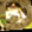

In [40]:
aug_list = [
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.4, hue=0.1),
    RandomRotateExpandTransform(25),
    transforms.RandomResizedCrop(size=32, scale=(0.7, 0.7), ratio=(1.0, 1.0)),
    transforms.ToTensor()
]

show_trans(aug_list)
trans_aug = transforms.Compose(aug_list)

In [ ]:
epochs = 100
vgg = Vgg16(0.3)
calls = control_callbacks(epochs, check_dir='./data/alex-checkpoints', show_bar=False)
full_data = PackDataset(full, transform=trans_aug)
net = NeuralNetClassifier(
    vgg,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.0001,
    batch_size=2048,
    max_epochs=epochs,
    train_split=predefined_split(test_data),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=calls,
    classes=list(range(10)),
)
net.fit(full_data, y=None)